# Regulation in the airline industry in Chile: relationship between service quality and market concentration

## Read Me
El siguiente código es un proyecto personal, tanto el código como la idea fueron elaborados por mí. El código cumple varias funciones:
- Automatiza la descarga de reportes en PDF con información de las aerolineas en Chile. Para esto utiliza webscrapping y procesamiento de texto.
- Utiliza la librería "tabula" de python para extraer bases de datos directamente desde reportes PDF.
- Finalmente utiliza las librerías "pandas" y "matplotlib" para desarrollar limpieza de datos, análisis estadístico y visualización.

### 0) Webscraping the data:

Optionally, you can use this code to download automatically the pdf reports with the tables used to contruct the airlines' punctuality index datasets.


#### First get the HTML code

In [4]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
import time

# Set up the Selenium WebDriver
s = Service("C:\\Users\\rafae\\Downloads\\chromedriver-win64\\chromedriver.exe")  # Update with your ChromeDriver path
driver = webdriver.Chrome(service=s)

# Website to be scrapped
driver.get("https://www.jac.gob.cl/santiago/")

time.sleep(2)  # Wait 2 seconds so website can load

# Html code:
html_content = driver.page_source
print("Number of characters in the HTML code:", len(html_content))


driver.quit()


Number of characters in the HTML code: 45175


Now let's find the links for each pdf report using beautiful soup

In [5]:
import requests
from bs4 import BeautifulSoup
import os


with open("extracted_html.txt", "r", encoding="utf-8") as file:
    html_content = file.read()


soup = BeautifulSoup(html_content, "html.parser")

base_url = "https://www.jac.gob.cl"
pdf_links = []
for link in soup.find_all("a", href=True):
    href = link["href"]
    if href.endswith(".pdf"):
        full_url = base_url + href if href.startswith("/") else href
        pdf_links.append(full_url)

pdf_links


['https://www.jac.gob.cl/wp-content/uploads/2024/01/Santiago-Oct-Dic-2023.pdf',
 'https://www.jac.gob.cl/wp-content/uploads/2023/01/Santiago-Oct-Dic-2022.pdf',
 'https://www.jac.gob.cl/wp-content/uploads/2022/01/Santiago-Oct-Dic-2021.pdf',
 'https://www.jac.gob.cl/wp-content/uploads/2021/01/Santiago-Oct-Dic-2020.pdf',
 'https://www.jac.gob.cl/wp-content/uploads/2020/01/Santiago-Oct-Dic-2019.pdf',
 'https://www.jac.gob.cl/wp-content/uploads/2024/10/Santiago-Jul-Sep-2024.pdf',
 'https://www.jac.gob.cl/wp-content/uploads/2023/10/Santiago-Jul-Sep-2023.pdf',
 'https://www.jac.gob.cl/wp-content/uploads/2022/10/Santiago-Jul-Sep-2022.pdf',
 'https://www.jac.gob.cl/wp-content/uploads/2021/10/Santiago-Jul-Sep-2021.pdf',
 'https://www.jac.gob.cl/wp-content/uploads/2020/10/Santiago-Jul-Sep-2020.pdf',
 'https://www.jac.gob.cl/wp-content/uploads/2014/10/Santiago-Jul-Sep-2019.pdf',
 'https://www.jac.gob.cl/wp-content/uploads/2024/07/Santiago-Abr-Jun-2024.pdf',
 'https://www.jac.gob.cl/wp-content/uplo

Now let's download the reports using selenium

In [6]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
import os
import time


chromedriver_path = "C:\\Users\\rafae\\Downloads\\chromedriver-win64\\chromedriver.exe"

service = Service(chromedriver_path)
options = webdriver.ChromeOptions()
options.add_experimental_option("prefs", {
    "download.default_directory": os.path.join(os.getcwd(), "downloaded_pdfs"),  # Set download directory
    "download.prompt_for_download": False,  # Disable download prompts
    "download.directory_upgrade": True,
    "plugins.always_open_pdf_externally": True  # Open PDFs directly in Chrome
})
driver = webdriver.Chrome(service=service, options=options)

download_dir = os.path.join(os.getcwd(), "downloaded_pdfs")
os.makedirs(download_dir, exist_ok=True)

for pdf_url in pdf_links:
    try:
        filename = os.path.join(download_dir, os.path.basename(pdf_url))
        if os.path.exists(filename):
            print(f"File exists. Replacing: {filename}")
            os.remove(filename)
        print(f"Downloading: {pdf_url}")
        driver.get(pdf_url) 
        time.sleep(3) 
    except Exception as e:
        print(f"Error downloading {pdf_url}: {e}")

driver.quit()

print("All downloads completed")


Downloading: https://www.jac.gob.cl/wp-content/uploads/2024/01/Santiago-Oct-Dic-2023.pdf
Downloading: https://www.jac.gob.cl/wp-content/uploads/2023/01/Santiago-Oct-Dic-2022.pdf
Downloading: https://www.jac.gob.cl/wp-content/uploads/2022/01/Santiago-Oct-Dic-2021.pdf
Downloading: https://www.jac.gob.cl/wp-content/uploads/2021/01/Santiago-Oct-Dic-2020.pdf
Downloading: https://www.jac.gob.cl/wp-content/uploads/2020/01/Santiago-Oct-Dic-2019.pdf
Downloading: https://www.jac.gob.cl/wp-content/uploads/2024/10/Santiago-Jul-Sep-2024.pdf
Downloading: https://www.jac.gob.cl/wp-content/uploads/2023/10/Santiago-Jul-Sep-2023.pdf
Downloading: https://www.jac.gob.cl/wp-content/uploads/2022/10/Santiago-Jul-Sep-2022.pdf
Downloading: https://www.jac.gob.cl/wp-content/uploads/2021/10/Santiago-Jul-Sep-2021.pdf
Downloading: https://www.jac.gob.cl/wp-content/uploads/2020/10/Santiago-Jul-Sep-2020.pdf
Downloading: https://www.jac.gob.cl/wp-content/uploads/2014/10/Santiago-Jul-Sep-2019.pdf
Downloading: https://

Finally let's change the name of the reports using regular expressions. This way we can later on extract the data using loops in an easier manner.

In [7]:
import os
import re

download_dir = os.path.join(os.getcwd(), "downloaded_pdfs")

if not os.path.exists(download_dir):
    print(f"Directory {download_dir} does not exist!")
    exit()

for filename in os.listdir(download_dir):
    if filename.endswith(".pdf"):
        if "Santiago-Ene-Mar-20191" in filename:
            new_name = "S20191.pdf"
        else:
            match = re.search(r"Santiago-(Ene-Mar|Abr-Jun|Jul-Sep|Oct-Dic)-(\d{4})", filename)
            if match:
                quarter_map = {"Ene-Mar": "1", "Abr-Jun": "2", "Jul-Sep": "3", "Oct-Dic": "4"}
                quarter = quarter_map[match.group(1)]
                year = match.group(2)
                new_name = f"S{year}{quarter}.pdf"
            else:
                print(f"Filename does not match the expected format: {filename}")
                continue
        
        # Define old and new file paths
        old_path = os.path.join(download_dir, filename)
        new_path = os.path.join(download_dir, new_name)
        
        if os.path.exists(new_path):
            print(f"File {new_name} already exists. Removing it.")
        
        os.rename(old_path, new_path)
        print(f"Renamed {filename} to {new_name}")

print("All files have been renamed")


Filename does not match the expected format: S20191.pdf
Filename does not match the expected format: S20192.pdf
Filename does not match the expected format: S20193.pdf
Filename does not match the expected format: S20194.pdf
Filename does not match the expected format: S20201.pdf
Filename does not match the expected format: S20202.pdf
Filename does not match the expected format: S20203.pdf
Filename does not match the expected format: S20204.pdf
Filename does not match the expected format: S20211.pdf
Filename does not match the expected format: S20212.pdf
Filename does not match the expected format: S20213.pdf
Filename does not match the expected format: S20214.pdf
Filename does not match the expected format: S20221.pdf
Filename does not match the expected format: S20222.pdf
Filename does not match the expected format: S20223.pdf
Filename does not match the expected format: S20224.pdf
Filename does not match the expected format: S20231.pdf
Filename does not match the expected format: S20

In [8]:
with open("extracted_html.txt", "w", encoding="utf-8") as file:
    file.write(html_content)


### 1) Extracting the "punctuality and regularity" datasets from the pdf reports.

- Since the datasets with information about Airlines average punctuality is not available publicly we will extract the tables directly from JAC's pdf reports using python's text mining techniques, specifically we will use the "tabula" package which allows to automatically identify and extract tables in pdfs. The reports can be downloaded from the "Informes Estadísticos de Regularidad y Puntualidad", specifically: https://www.jac.gob.cl/santiago/ .

- We will use the tabula package to extract the "punctuality" tables form each pdf file.



# Important

in order to replicate this code, you need to install java by running jdk-23_windows-x64_bin (download from https://www.oracle.com/cl/java/technologies/downloads/#jdk23-windows , choose the most appropriate installer for your system)

In [11]:
import os
import tabula
import pandas as pd


# 1) First install Java and make sure it is working in the current environment
java_path = r'C:\Program Files\Java\jdk-23\bin' 
os.environ['PATH'] = java_path + ';' + os.environ['PATH']

# Directory 
pdf_directory = r"C:\Users\rafae\Documents\github\proyectos\regulation_airlines_fne\downloaded_pdfs"

# List of pdf's filenames 
pdf_files = [
    'S20191.pdf', 'S20192.pdf', 'S20193.pdf', 'S20194.pdf', 'S20201.pdf',
    'S20222.pdf', 'S20223.pdf', 'S20224.pdf', 'S20231.pdf', 'S20232.pdf', 'S20233.pdf', 'S20234.pdf',
    'S20241.pdf', 'S20242.pdf'
]

dfs = []
dfs_dic={}


count=0
for pdf_file in pdf_files:
    count=count+1
    pdf_path = os.path.join(pdf_directory, pdf_file)
    print("")
    print("File number :", count)
    print(pdf_path)
    encodings = ["utf-8", "ISO-8859-1", "windows-1252", "ISO-8859-2", "utf-16"]
    tabular_data = tabula.read_pdf(pdf_path, pages="all", multiple_tables=True, encoding="ISO-8859-1")
    
   
# Position of tables to be extracted
#20191-20231 = 0
#20232 = 6
#20233 = 6
#20234 = 6
#20241 = 21
#20242: 11


# Now using tabula we select what table we want to get from each pdf, we are looking for the tables that display the average punctuality index for each airline in chile
    if pdf_file in ['S20191.pdf', 'S20192.pdf', 'S20193.pdf', 'S20194.pdf', 'S20201.pdf', 'S20222.pdf', 'S20223.pdf', 'S20224.pdf', 'S20231.pdf']:
        first_table = tabular_data[0]
    elif pdf_file in ["S20232.pdf" ,"S20233.pdf" ,"S20234.pdf"]:
        first_table = tabular_data[6]
    elif pdf_file=="S20241.pdf":
        first_table = tabular_data[21]
    elif pdf_file=="S20242.pdf":
        first_table = tabular_data[11]
           
    
    dfs_dic[pdf_file] = first_table
    
    print("")


Failed to import jpype dependencies. Fallback to subprocess.
No module named 'jpype'



File number : 1
C:\Users\rafae\Documents\github\proyectos\regulation_airlines_fne\downloaded_pdfs\S20191.pdf


File number : 2
C:\Users\rafae\Documents\github\proyectos\regulation_airlines_fne\downloaded_pdfs\S20192.pdf


File number : 3
C:\Users\rafae\Documents\github\proyectos\regulation_airlines_fne\downloaded_pdfs\S20193.pdf


File number : 4
C:\Users\rafae\Documents\github\proyectos\regulation_airlines_fne\downloaded_pdfs\S20194.pdf


File number : 5
C:\Users\rafae\Documents\github\proyectos\regulation_airlines_fne\downloaded_pdfs\S20201.pdf


File number : 6
C:\Users\rafae\Documents\github\proyectos\regulation_airlines_fne\downloaded_pdfs\S20222.pdf


File number : 7
C:\Users\rafae\Documents\github\proyectos\regulation_airlines_fne\downloaded_pdfs\S20223.pdf


File number : 8
C:\Users\rafae\Documents\github\proyectos\regulation_airlines_fne\downloaded_pdfs\S20224.pdf


File number : 9
C:\Users\rafae\Documents\github\proyectos\regulation_airlines_fne\downloaded_pdfs\S20231.pdf




### 2) Cleaning the extracted datasets (part 1)

- Now that we have save the datasets as dataframes using pandas, we will work on cleaning each one of them so we can later merge them all together 

#### 2 a) dataset S20191

In [14]:

print("Data cleaning: S20191.pdf")
df=dfs_dic["S20191.pdf"]
print(df)
print("1) delete first 2 rows")
df = df.drop([0, 1]).reset_index(drop=True)


print("2) split column with 2 values")
df[['Regularity', 'Punctuality']] = df['Porcentaje Vuelos (%)'].str.split(expand=True)
#print(dfS20191)

print("3) rename columns")
df = df.rename(columns={
    'Unnamed: 0': 'Airline',  
    'Cantidad': 'Number of Flights', 
    'Regularity': 'Regularity (%)', 
    'Punctuality': 'Punctuality (%)'
})


print("4) adjust numeric format")
print(df['Regularity (%)'].dtype)
df = df[["Airline","Number of Flights" , 'Punctuality (%)']]
df['Number of Flights'] = df['Number of Flights'].str.replace('.', '', regex=False)
df['Number of Flights'] = pd.to_numeric(df['Number of Flights'], errors='coerce')
df['Punctuality (%)'] = df['Punctuality (%)'].str.replace(',', '.', regex=False)
df['Punctuality (%)'] = pd.to_numeric(df['Punctuality (%)'], errors='coerce')


dfS20191=df
dfS20191

Data cleaning: S20191.pdf
                Unnamed: 0    Porcentaje Vuelos (%)   Cantidad
0               OPERADORES                      NaN         de
1                      NaN  Regularidad Puntualidad  Despegues
2    Aerolineas Argentinas                99,3 82,7        234
3               Aeromexico               100,0 86,7         78
4               Air Canada               100,0 51,6         33
5               Air France                98,9 91,1         82
6                 Alitalia               100,0 84,6         55
7        American Airlines                99,5 87,3        172
8                  Austral                97,3 72,2         52
9                  Avianca               100,0 56,8        151
10         British Airways               100,0 87,5         56
11                Copa Air                99,8 95,0        460
12               Delta Air               100,0 96,7         87
13                Emirates               100,0 90,7         49
14   Estelar Latinoamerica   

,Airline,Number of Flights,Punctuality (%)
0,Aerolineas Argentinas,234,82.7
1,Aeromexico,78,86.7
2,Air Canada,33,51.6
3,Air France,82,91.1
4,Alitalia,55,84.6
5,American Airlines,172,87.3
6,Austral,52,72.2
7,Avianca,151,56.8
8,British Airways,56,87.5
9,Copa Air,460,95.0


#### 2 b) dataset S20192

In [16]:
print("Data cleaning: S20192.pdf")
df=dfs_dic["S20192.pdf"]
print(df)

print("1) delete first 2 rows")
df = df.drop([0, 1]).reset_index(drop=True)



print("2) split column with 2 values")
df[['Regularity', 'Punctuality']] = df['Porcentaje Vuelos (%)'].str.split(expand=True)


print("3) rename columns")
df = df.rename(columns={
    'Unnamed: 0': 'Airline',  
    'Cantidad': 'Number of Flights', 
    'Regularity': 'Regularity (%)', 
    'Punctuality': 'Punctuality (%)'
})

print("4) adjust numeric format")
df = df[["Airline","Number of Flights" , 'Punctuality (%)']]
df['Number of Flights'] = df['Number of Flights'].str.replace('.', '', regex=False)
df['Number of Flights'] = pd.to_numeric(df['Number of Flights'], errors='coerce')
df['Punctuality (%)'] = df['Punctuality (%)'].str.replace(',', '.', regex=False)
df['Punctuality (%)'] = pd.to_numeric(df['Punctuality (%)'], errors='coerce')


dfS20192=df
dfS20192

Data cleaning: S20192.pdf
                Unnamed: 0    Porcentaje Vuelos (%)   Cantidad
0               OPERADORES                      NaN         de
1                      NaN  Regularidad Puntualidad  Despegues
2    Aerolineas Argentinas               100,0 80,1        269
3               Aeromexico                97,8 85,4         76
4               Air Canada               100,0 86,4         89
5               Air France               100,0 89,0         81
6                 Alitalia                98,5 89,2         58
7        American Airlines                99,5 89,6        163
8                  Austral               100,0 50,8         32
9                  Avianca                99,6 78,5        215
10         British Airways               100,0 87,7         57
11                Copa Air                99,5 92,5        409
12               Delta Air                98,9 95,6         87
13                Emirates               100,0 97,6         41
14   Estelar Latinoamerica   

,Airline,Number of Flights,Punctuality (%)
0,Aerolineas Argentinas,269,80.1
1,Aeromexico,76,85.4
2,Air Canada,89,86.4
3,Air France,81,89.0
4,Alitalia,58,89.2
5,American Airlines,163,89.6
6,Austral,32,50.8
7,Avianca,215,78.5
8,British Airways,57,87.7
9,Copa Air,409,92.5


#### 2 c) S20193

In [18]:

print("Data cleaning: S20193.pdf")
df=dfs_dic["S20193.pdf"]
print(df)


print("1) delete first 2 rows")
df = df.drop([0, 1]).reset_index(drop=True)



print("2) split column with 2 values")
df[['Regularity', 'Punctuality']] = df['Porcentaje Vuelos (%)'].str.split(expand=True)


print("3) rename columns")
df = df.rename(columns={
    'Unnamed: 0': 'Airline',  
    'Cantidad': 'Number of Flights', 
    'Regularity': 'Regularity (%)', 
    'Punctuality': 'Punctuality (%)'
})

df = df[["Airline","Number of Flights" , 'Punctuality (%)']]
df['Number of Flights'] = df['Number of Flights'].str.replace('.', '', regex=False)
df['Number of Flights'] = pd.to_numeric(df['Number of Flights'], errors='coerce')
df['Punctuality (%)'] = df['Punctuality (%)'].str.replace(',', '.', regex=False)
df['Punctuality (%)'] = pd.to_numeric(df['Punctuality (%)'], errors='coerce')


dfS20193=df
dfS20193

Data cleaning: S20193.pdf
                       Unnamed: 0    Porcentaje Vuelos (%)   Cantidad
0                      OPERADORES                      NaN         de
1                             NaN  Regularidad Puntualidad  Despegues
2   Aerolineas Argentinas-Austral                95,5 85,6        379
3                      Aeromexico               100,0 84,8         78
4                      Air Canada               100,0 80,2         85
5                      Air France                98,9 98,9         90
6                        Alitalia               100,0 89,2         58
7               American Airlines                99,5 89,1        163
8                 British Airways               100,0 88,9         56
9                        Copa Air               100,0 94,6        439
10                      Delta Air                98,9 91,3         84
11                       Emirates              100,0 100,0         39
12          Estelar Latinoamerica               100,0 70,4      

,Airline,Number of Flights,Punctuality (%)
0,Aerolineas Argentinas-Austral,379,85.6
1,Aeromexico,78,84.8
2,Air Canada,85,80.2
3,Air France,90,98.9
4,Alitalia,58,89.2
5,American Airlines,163,89.1
6,British Airways,56,88.9
7,Copa Air,439,94.6
8,Delta Air,84,91.3
9,Emirates,39,100.0


#### 2 d) S20194

In [20]:

print("Data cleaning: S20194.pdf")
df=dfs_dic["S20194.pdf"]
print(df)



df = df.drop([0, 1]).reset_index(drop=True)

df[['Regularity', 'Punctuality']] = df['Porcentaje Vuelos (%)'].str.split(expand=True)


df = df.rename(columns={
    'Unnamed: 0': 'Airline',  
    'Cantidad': 'Number of Flights',  
    'Regularity': 'Regularity (%)', 
    'Punctuality': 'Punctuality (%)'
})

df = df[["Airline","Number of Flights" , 'Punctuality (%)']]
df['Number of Flights'] = df['Number of Flights'].str.replace('.', '', regex=False)
df['Number of Flights'] = pd.to_numeric(df['Number of Flights'], errors='coerce')
df['Punctuality (%)'] = df['Punctuality (%)'].str.replace(',', '.', regex=False)
df['Punctuality (%)'] = pd.to_numeric(df['Punctuality (%)'], errors='coerce')


dfS20194=df
dfS20194

Data cleaning: S20194.pdf
                       Unnamed: 0    Porcentaje Vuelos (%)   Cantidad
0                      OPERADORES                      NaN         de
1                             NaN  Regularidad Puntualidad  Despegues
2   Aerolineas Argentinas-Austral                90,3 76,5        284
3                      Aeromexico               100,0 90,2         83
4                      Air Canada               100,0 61,4         81
5                      Air France                99,0 88,5         92
6                        Alitalia                98,6 94,2         65
7               American Airlines               100,0 94,3        181
8                 British Airways                98,5 94,0         63
9                        Copa Air               100,0 94,2        405
10                      Delta Air                98,9 95,7         88
11                       Emirates               100,0 97,4         38
12          Estelar Latinoamerica               100,0 57,7      

,Airline,Number of Flights,Punctuality (%)
0,Aerolineas Argentinas-Austral,284,76.5
1,Aeromexico,83,90.2
2,Air Canada,81,61.4
3,Air France,92,88.5
4,Alitalia,65,94.2
5,American Airlines,181,94.3
6,British Airways,63,94.0
7,Copa Air,405,94.2
8,Delta Air,88,95.7
9,Emirates,38,97.4


#### 2 e)  S20201

In [22]:

print("Data cleaning: S20201.pdf")
df=dfs_dic["S20201.pdf"]
print(df)



df = df.drop([0, 1]).reset_index(drop=True)



df = df.rename(columns={
    'Unnamed: 0': 'Airline',  
    'Cantidad': 'Number of Flights',  
    '(%) de': 'Punctuality (%)', 
    'Promedio': "Delay (minutes)",
    "(%) de.1": "Regularity (%)"
})

df = df[["Airline","Number of Flights" , 'Punctuality (%)']]
df['Number of Flights'] = df['Number of Flights'].str.replace('.', '', regex=False)
df['Number of Flights'] = pd.to_numeric(df['Number of Flights'], errors='coerce')
df['Punctuality (%)'] = df['Punctuality (%)'].str.replace(',', '.', regex=False)
df['Punctuality (%)'] = pd.to_numeric(df['Punctuality (%)'], errors='coerce')



dfS20201=df
dfS20201

Data cleaning: S20201.pdf
                  Unnamed: 0    Cantidad     (%) de    Promedio   (%) de.1
0                 OPERADORES   de vuelos     vuelos     minutos     vuelos
1                        NaN  realizados  puntuales  de atrasos  regulares
2                   Emirates          30      100,0         NaN      100,0
3                   Copa Air         337       97,6          34      100,0
4                   Alitalia          49       95,9          21      100,0
5                     K.L.M.          68       95,6          57      100,0
6               Iberia-Level         134       93,3          31       99,3
7                 Air France          97       92,8          28      100,0
8                  Gol Trans         153       92,2          94      100,0
9                Sky Airline       3.500       92,2          52       99,9
10               Grupo LATAM       9.411       91,7          49       99,7
11                Aeromexico          68       91,2          84      100,0

,Airline,Number of Flights,Punctuality (%)
0,Emirates,30,100.0
1,Copa Air,337,97.6
2,Alitalia,49,95.9
3,K.L.M.,68,95.6
4,Iberia-Level,134,93.3
5,Air France,97,92.8
6,Gol Trans,153,92.2
7,Sky Airline,3500,92.2
8,Grupo LATAM,9411,91.7
9,Aeromexico,68,91.2


#### 2 f)  S20201

In [24]:

print("Data cleaning: S20222.pdf")
df=dfs_dic["S20222.pdf"]
print(df)


df = df.drop([0, 1]).reset_index(drop=True)

df = df.rename(columns={
    'Unnamed: 0': 'Airline',  
    'Cantidad': 'Number of Flights', 
    '(%) de': 'Punctuality (%)', 
    'Promedio': "Delay (minutes)",
    "(%) de.1": "Regularity (%)"
})


df = df[["Airline","Number of Flights" , 'Punctuality (%)']]
df['Number of Flights'] = df['Number of Flights'].str.replace('.', '', regex=False)
df['Number of Flights'] = pd.to_numeric(df['Number of Flights'], errors='coerce')
df['Punctuality (%)'] = df['Punctuality (%)'].str.replace(',', '.', regex=False)
df['Punctuality (%)'] = pd.to_numeric(df['Punctuality (%)'], errors='coerce')



dfS20222=df
df


Data cleaning: S20222.pdf
                       Unnamed: 0    Cantidad     (%) de    Promedio  \
0                             NaN   de vuelos     vuelos     minutos   
1                LINEAS AEREAS EN  realizados  puntuales  de atrasos   
2                      Air France          65       83,1          23   
3                        Copa Air         481       91,7          55   
4                     Sky Airline       2.666       92,2          41   
5                     Grupo LATAM       6.957       91,7          51   
6   Aerolineas Argentinas-Austral         240       84,2          40   
7                   Grupo Avianca         272       87,5          55   
8                    Iberia-Level          91       82,4          22   
9                        JetSmart       1.482       83,7          55   
10                     Aeromexico          91       98,9          33   
11              American Airlines         165       91,5         115   
12                         K.L.M.     

,Airline,Number of Flights,Punctuality (%)
0,Air France,65,83.1
1,Copa Air,481,91.7
2,Sky Airline,2666,92.2
3,Grupo LATAM,6957,91.7
4,Aerolineas Argentinas-Austral,240,84.2
5,Grupo Avianca,272,87.5
6,Iberia-Level,91,82.4
7,JetSmart,1482,83.7
8,Aeromexico,91,98.9
9,American Airlines,165,91.5


#### 2 )

In [26]:

print("Data cleaning: S20223.pdf")
df=dfs_dic["S20223.pdf"]
print(df)


print("1) borrar 2 primeras observaciones")
df = df.drop([0, 1]).reset_index(drop=True)


df = df.rename(columns={
    'Unnamed: 0': 'Airline',  
    'Cantidad': 'Number of Flights',  
    '(%) de': 'Punctuality (%)', 
    'Promedio': "Delay (minutes)",
    "(%) de.1": "Regularity (%)"
})

df = df[["Airline","Number of Flights" , 'Punctuality (%)']]
df['Number of Flights'] = df['Number of Flights'].str.replace('.', '', regex=False)
df['Number of Flights'] = pd.to_numeric(df['Number of Flights'], errors='coerce')
df['Punctuality (%)'] = df['Punctuality (%)'].str.replace(',', '.', regex=False)
df['Punctuality (%)'] = pd.to_numeric(df['Punctuality (%)'], errors='coerce')



dfS20223=df
df

Data cleaning: S20223.pdf
                       Unnamed: 0    Cantidad     (%) de    Promedio  \
0                             NaN   de vuelos     vuelos     minutos   
1                LINEAS AEREAS EN  realizados  puntuales  de atrasos   
2                      Air France          69       89,9          62   
3                        Copa Air         527       92,6          39   
4                     Sky Airline       3.081       89,5          40   
5                     Grupo LATAM       8.107       90,7          44   
6   Aerolineas Argentinas-Austral         248       84,7          37   
7                   Grupo Avianca         267       90,6         140   
8                    Iberia-Level          92       89,1          74   
9                        JetSmart       1.386       81,7          57   
10                     Aeromexico          83       98,8         129   
11              American Airlines         131       90,8         241   
12                         K.L.M.     

,Airline,Number of Flights,Punctuality (%)
0,Air France,69,89.9
1,Copa Air,527,92.6
2,Sky Airline,3081,89.5
3,Grupo LATAM,8107,90.7
4,Aerolineas Argentinas-Austral,248,84.7
5,Grupo Avianca,267,90.6
6,Iberia-Level,92,89.1
7,JetSmart,1386,81.7
8,Aeromexico,83,98.8
9,American Airlines,131,90.8


#### 2 )

In [28]:

print("Data cleaning: S20224.pdf")
df=dfs_dic["S20224.pdf"]
print(df)

df = df.drop([0, 1]).reset_index(drop=True)


df = df.rename(columns={
    'Unnamed: 0': 'Airline', 
    'Cantidad': 'Number of Flights', 
    '(%) de': 'Punctuality (%)', 
    'Promedio': "Delay (minutes)",
    "(%) de.1": "Regularity (%)"
})


df = df[["Airline","Number of Flights" , 'Punctuality (%)']]
df['Number of Flights'] = df['Number of Flights'].str.replace('.', '', regex=False)
df['Number of Flights'] = pd.to_numeric(df['Number of Flights'], errors='coerce')
df['Punctuality (%)'] = df['Punctuality (%)'].str.replace(',', '.', regex=False)
df['Punctuality (%)'] = df['Punctuality (%)'].str.replace('%', '', regex=False)
df['Punctuality (%)'] = pd.to_numeric(df['Punctuality (%)'], errors='coerce')



dfS20224=df
df

Data cleaning: S20224.pdf
                       Unnamed: 0    Cantidad     (%) de    Promedio  \
0                             NaN   de vuelos     vuelos     minutos   
1                LÍNEAS AÉREAS EN  realizados  puntuales  de atrasos   
2                 United Airlines          92      94,6%         206   
3                      Air France          89      92,1%         396   
4                         Avianca         271      90,8%          83   
5                     Sky Airline       3.516      90,8%          37   
6   Aerolineas Argentinas-Austral         248      90,3%          50   
7                      Aeromexico          66      89,4%         101   
8                           LATAM       8.782      88,3%          42   
9                        Copa Air         504      88,1%          31   
10              American Airlines         192      87,0%         104   
11                     Air Canada          49      83,7%          53   
12                         K.L.M.     

,Airline,Number of Flights,Punctuality (%)
0,United Airlines,92,94.6
1,Air France,89,92.1
2,Avianca,271,90.8
3,Sky Airline,3516,90.8
4,Aerolineas Argentinas-Austral,248,90.3
5,Aeromexico,66,89.4
6,LATAM,8782,88.3
7,Copa Air,504,88.1
8,American Airlines,192,87.0
9,Air Canada,49,83.7


#### 2 )

In [30]:

print("Data cleaning: S20231.pdf")
df=dfs_dic["S20231.pdf"]
print(df)


df = df.drop([0, 1]).reset_index(drop=True)


df = df.rename(columns={
    'Unnamed: 0': 'Airline',  
    'Cantidad': 'Number of Flights',  
    '(%) de': 'Punctuality (%)', 
    'Promedio': "Delay (minutes)",
    "(%) de.1": "Regularity (%)"
})

df = df[["Airline","Number of Flights" , 'Punctuality (%)']]
df['Number of Flights'] = df['Number of Flights'].str.replace('.', '', regex=False)
df['Number of Flights'] = pd.to_numeric(df['Number of Flights'], errors='coerce')
df['Punctuality (%)'] = df['Punctuality (%)'].str.replace(',', '.', regex=False)
df['Punctuality (%)'] = df['Punctuality (%)'].str.replace('%', '', regex=False)
df['Punctuality (%)'] = pd.to_numeric(df['Punctuality (%)'], errors='coerce')


print(type(df["Number of Flights"]))
dfS20231=df
df

Data cleaning: S20231.pdf
                       Unnamed: 0    Cantidad     (%) de    Promedio  \
0                             NaN   de vuelos     vuelos     minutos   
1                LÍNEAS AÉREAS EN  realizados  puntuales  de atrasos   
2                        Copa Air         486      96,5%          35   
3                 United Airlines          90      95,6%          47   
4                   Grupo Avianca         312      93,9%          56   
5                       Delta Air          90      92,2%          75   
6               American Airlines         177      92,1%         299   
7                     Sky Airline       4.069      92,0%          42   
8                     Grupo LATAM       9.539      91,5%          45   
9                          K.L.M.          90      90,0%          54   
10                     Aeromexico          76      89,5%         278   
11  Aerolineas Argentinas-Austral         242      88,4%          38   
12                     Air France     

,Airline,Number of Flights,Punctuality (%)
0,Copa Air,486,96.5
1,United Airlines,90,95.6
2,Grupo Avianca,312,93.9
3,Delta Air,90,92.2
4,American Airlines,177,92.1
5,Sky Airline,4069,92.0
6,Grupo LATAM,9539,91.5
7,K.L.M.,90,90.0
8,Aeromexico,76,89.5
9,Aerolineas Argentinas-Austral,242,88.4


#### 2 )

In [32]:

print("Data cleaning: S20232.pdf")
df=dfs_dic["S20232.pdf"]
print(df.head())


column_names = list(df.columns)
print(column_names)
#['Línea Aérea', 'Cantidad de\rvuelos\rprogramados', 'Cantidad de\rvuelos\rrealizados', '% de vuelos\rregulares', 'Cantidad de\rvuelos\rpuntuales', 
#'% de vuelos\rpuntuales', '% de atraso\rentre 16 y 30\rmin.', '% de atraso\rentre 31 y 60\rmin.', '% de atraso\rmayor a 60\rmin.']


df=df[["Línea Aérea", 'Cantidad de\rvuelos\rprogramados', "Cantidad de\rvuelos\rrealizados", "% de vuelos\rregulares" , "% de vuelos\rpuntuales"]]

df = df.rename(columns={
    'Línea Aérea': 'Airline',  
    'Cantidad de\rvuelos\rrealizados': 'Number of Flights',  
    '% de vuelos\rpuntuales': 'Punctuality (%)', 
    "% de vuelos\rregulares": "Regularity (%)"
})

df = df[["Airline","Number of Flights" , 'Punctuality (%)']]
df['Number of Flights'] = df['Number of Flights'].str.replace('.', '', regex=False).str.replace(' ', '', regex=False)
df['Number of Flights'] = pd.to_numeric(df['Number of Flights'], errors='coerce')
df['Punctuality (%)'] = df['Punctuality (%)'].str.replace(',', '.', regex=False)
df['Punctuality (%)'] = df['Punctuality (%)'].str.replace('%', '', regex=False)
df['Punctuality (%)'] = pd.to_numeric(df['Punctuality (%)'], errors='coerce')

dfS20232=df
df


Data cleaning: S20232.pdf
         Línea Aérea Cantidad de\rvuelos\rprogramados  \
0               COPA                             4 60   
1         AIR FRANCE                              9 1   
2    BRITISH AIRWAYS                              5 3   
3  AMERICAN AIRLINES                             1 31   
4     DELTA AIRLINES                              9 3   

  Cantidad de\rvuelos\rrealizados % de vuelos\rregulares  \
0                            4 60                 100,0%   
1                             9 1                   100%   
2                             5 2                  98,1%   
3                            1 31                   100%   
4                             9 1                  97,8%   

  Cantidad de\rvuelos\rpuntuales % de vuelos\rpuntuales  \
0                           4 46                  97,0%   
1                            8 7                  95,6%   
2                            4 9                  94,2%   
3                           1 23  

,Airline,Number of Flights,Punctuality (%)
0,COPA,460,97.0
1,AIR FRANCE,91,95.6
2,BRITISH AIRWAYS,52,94.2
3,AMERICAN AIRLINES,131,93.9
4,DELTA AIRLINES,91,91.2
5,UNITED AIRLINES,90,90.0
6,LATAM,3031,89.6
7,AVIANCA,299,87.6
8,IBERIA,104,87.5
9,SKY AIRLINE,803,86.4


#### 2 )

In [34]:

print("Data cleaning: S20233.pdf")
df=dfs_dic["S20233.pdf"]
df
#print(df.head())
#df.head()


column_names = list(df.columns)
print(column_names)
#['Línea Aérea', 'Cantidad de\rvuelos\rprogramados', 'Cantidad de\rvuelos\rrealizados', '% de vuelos\rregulares', 'Cantidad de\rvuelos\rpuntuales', 
#'% de vuelos\rpuntuales', '% de atraso\rentre 16 y 30\rmin.', '% de atraso\rentre 31 y 60\rmin.', '% de atraso\rmayor a 60\rmin.']


print("2) keep only useful columns")

df=df[["Línea Aérea",'Cantidad de\rvuelos\rprogramados', "Cantidad de\rvuelos\rrealizados", "% de vuelos\rregulares" , "% de vuelos\rpuntuales"]]


df = df.rename(columns={
    'Línea Aérea': 'Airline', 
    'Cantidad de\rvuelos\rprogramados': 'Number of Flights',  
    '% de vuelos\rpuntuales': 'Punctuality (%)', 
    "% de vuelos\rregulares": "Regularity (%)"
})

df = df[["Airline","Number of Flights" , 'Punctuality (%)']]
df['Number of Flights'] = df['Number of Flights'].str.replace('.', '', regex=False).str.replace(' ', '', regex=False)
df['Number of Flights'] = pd.to_numeric(df['Number of Flights'], errors='coerce')
df['Punctuality (%)'] = df['Punctuality (%)'].str.replace(',', '.', regex=False)
df['Punctuality (%)'] = df['Punctuality (%)'].str.replace('%', '', regex=False)
df['Punctuality (%)'] = pd.to_numeric(df['Punctuality (%)'], errors='coerce')

print(type(df["Number of Flights"]))
dfS20233=df
#df

Data cleaning: S20233.pdf
['Línea Aérea', 'Unnamed: 0', 'Cantidad de\rvuelos\rprogramados', 'Unnamed: 1', 'Cantidad de\rvuelos\rrealizados', '% de vuelos\rregulares', 'Cantidad de\rvuelos\rpuntuales', '% de vuelos\rpuntuales', '% de atraso\rentre 16 y 30\rmin.', '% de atraso\rentre 31 y 60\r97m%i n.', '% de atraso\rmayor a 60\rmin.', 'Unnamed: 2']
2) keep only useful columns
<class 'pandas.core.series.Series'>


#### 2 )

In [36]:


print("Data cleaning: S20234.pdf")
df=dfs_dic["S20234.pdf"]
print(df.head())
#df.head()



column_names = list(df.columns)
print(column_names)
#['Línea Aérea', 'Cantidad de\rvuelos\rprogramados', 'Cantidad de\rvuelos\rrealizados', '% de vuelos\rregulares', 'Cantidad de\rvuelos\rpuntuales', 
#'% de vuelos\rpuntuales', '% de atraso\rentre 16 y 30\rmin.', '% de atraso\rentre 31 y 60\rmin.', '% de atraso\rmayor a 60\rmin.']



df=df[["Línea Aérea",'Cantidad de\rvuelos\rprogramados', 'Cantidad de\rvuelos\rpuntuales', "Cantidad de\rvuelos\rrealizados", "% de vuelos\rregulares\r6%" , "% de vuelos\rpuntuales"]]


df

Data cleaning: S20234.pdf
         Línea Aérea Cantidad de\rvuelos\rprogramados  \
0         AEROMEXICO                              4 9   
1         AIR CANADA                              6 0   
2         AIR FRANCE                              9 2   
3  AMERICAN AIRLINES                             1 68   
4    BRITISH AIRWAYS                              5 2   

  Cantidad de\rvuelos\rrealizados % de vuelos\rregulares\r6%  \
0                            4 94                     100,0%   
1                             6 0                       100%   
2                             9 2            10%\r151%0 0,0%   
3                            1 68                       100%   
4                             5 2             151%00 7%\r,0%   

  Cantidad de\rvuelos\rpuntuales % de vuelos\rpuntuales  \
0                            4 3                  87,8%   
1                            3 5              58% 58,3%   
2                            6 7                  72,8%   
3         

,Línea Aérea,Cantidad de\rvuelos\rprogramados,Cantidad de\rvuelos\rpuntuales,Cantidad de\rvuelos\rrealizados,% de vuelos\rregulares\r6%,% de vuelos\rpuntuales
0,AEROMEXICO,4 9,4 3,4 94,"100,0%","87,8%"
1,AIR CANADA,6 0,3 5,6 0,100%,"58% 58,3%"
2,AIR FRANCE,9 2,6 7,9 2,"10%\r151%0 0,0%","72,8%"
3,AMERICAN AIRLINES,1 68,1 51,1 68,100%,"89,9%7"
4,BRITISH AIRWAYS,5 2,4 2,5 2,"151%00 7%\r,0%","80,8%"
5,ESTELAR LATINOAMERICA,2 8,6,2 0,"%\r71,4%","30,0%"
6,JETSMART,8 84,5 77,8 45,"6%95,6%","68,3%"
7,SKY AIRLINE,1 .136,8 56,1 .1273,"99,2%","76,0%"
8,STAR UP SA,5,5,5,"100,0%","100,0%"
9,UNITED AIRLINES,9 2,8 8,9 2,"12% 100,0%","95,7%"


#### 2 )

In [38]:

print("Data cleaning: S20241.pdf")
df=dfs_dic["S20241.pdf"]
print(df.head())
#df.head()


column_names = list(df.columns)
print(column_names)
#['Línea Aérea', 'Cantidad de\rvuelos\rprogramados', 'Cantidad de\rvuelos\rrealizados', '% de vuelos\rregulares', 'Cantidad de\rvuelos\rpuntuales', 
#'% de vuelos\rpuntuales', '% de atraso\rentre 16 y 30\rmin.', '% de atraso\rentre 31 y 60\rmin.', '% de atraso\rmayor a 60\rmin.']


df=df[["Línea Aérea",'Cantidad de\rvuelos\rprogramados', 'Cantidad de\rvuelos\rpuntuales', 
       "Cantidad de\rvuelos\rrealizados", "% de vuelos\rpuntuales"]]


print("3) rename columns")
#Unnamed: 0    Cantidad     (%) de    Promedio   (%) de.1

df = df.rename(columns={
    'Línea Aérea': 'Airline',  
    'Cantidad de\rvuelos\rprogramados': 'Number of Flights',
    'Cantidad de\rvuelos\rpuntuales': "Number of punctuality",
    '% de vuelos\rpuntuales': 'Punctuality (%)', 
    "% de vuelos\rregulares": "Regularity (%)"
})

df = df[["Airline","Number of Flights" , 'Punctuality (%)']]

df['Number of Flights'] = df['Number of Flights'].str.replace('.', '', regex=False).str.replace(' ', '', regex=False)
df['Number of Flights'] = pd.to_numeric(df['Number of Flights'], errors='coerce')

df['Punctuality (%)'] = df['Punctuality (%)'].str.extract(r'(\d{2},\d)')

df['Punctuality (%)'] = df['Punctuality (%)'].str.replace('00,0', '100,0', regex=False).str.replace(',', '.', regex=False)

df['Punctuality (%)'] = pd.to_numeric(df['Punctuality (%)'], errors='coerce')
df.fillna(0, inplace=True)

print(type(df["Number of Flights"]))
dfS20241=df
df

Data cleaning: S20241.pdf
             Línea Aérea Cantidad de\rvuelos\rprogramados  \
0  AEROLÍNEAS ARGENTINAS                             3 42   
1             AEROMEXICO                              7 1   
2             AIR CANADA                              6 4   
3             AIR FRANCE                              9 3   
4              AMASZONAS                                3   

  Cantidad de\rvuelos\rrealizados % de vuelos\rregulares  \
0                            3 30                  96,5%   
1                             7 1                 5%100%   
2                             6 4                 100,0%   
3                            9 11                    98%   
4                               3              %\r100,0%   

  Cantidad de\rvuelos\rpuntuales % de vuelos\rpuntuales  Unnamed: 0  \
0                           2 65                  80,3%         NaN   
1                            6 5                  91,5%         NaN   
2                            3 6 

,Airline,Number of Flights,Punctuality (%)
0,AEROLÍNEAS ARGENTINAS,342,80.3
1,AEROMEXICO,71,91.5
2,AIR CANADA,64,56.3
3,AIR FRANCE,93,56.0
4,AMASZONAS,3,0.0
5,AMERICAN AIRLINES,182,94.0
6,ARAJET,38,81.6
7,AVIANCA,298,90.6
8,BRITISH AIRWAYS,53,69.8
9,COPA,477,92.6


#### 2 )

In [40]:

print("Data cleaning: S20242.pdf")
df=dfs_dic["S20242.pdf"]
print(df.head())
#df.head()



print("1) borrar 2 primeras observaciones")
#df = df.drop([0, 1]).reset_index(drop=True)

column_names = list(df.columns)
print(column_names)
#['Línea Aérea', 'Cantidad de\rvuelos\rprogramados', 'Cantidad de\rvuelos\rrealizados', '% de vuelos\rregulares', 'Cantidad de\rvuelos\rpuntuales', 
#'% de vuelos\rpuntuales', '% de atraso\rentre 16 y 30\rmin.', '% de atraso\rentre 31 y 60\rmin.', '% de atraso\rmayor a 60\rmin.']


print("2) keep only useful columns")

df=df[["Línea Aérea",'Cantidad de\rvuelos\rprogramados', 'Cantidad de\rvuelos\rpuntuales', 
       "Cantidad de\rvuelos\rrealizados", "% de vuelos\rpuntuales"]]


print("3) rename columns")
#Unnamed: 0    Cantidad     (%) de    Promedio   (%) de.1

df = df.rename(columns={
    'Línea Aérea': 'Airline',  
    'Cantidad de\rvuelos\rrealizados': 'Number of Flights',
    'Cantidad de\rvuelos\rpuntuales': "Number of punctuality", 
    '% de vuelos\rpuntuales': 'Punctuality (%)', 
    "% de vuelos\rregulares": "Regularity (%)"
})


df = df[["Airline","Number of Flights" , 'Punctuality (%)']]

df['Number of Flights'] = df['Number of Flights'].str.replace('.', '', regex=False).str.replace(' ', '', regex=False)
df['Number of Flights'] = pd.to_numeric(df['Number of Flights'], errors='coerce')

df['Punctuality (%)'] = df['Punctuality (%)'].str.replace(',', '.', regex=False).str.replace('%', '', regex=False)

df['Punctuality (%)'] = pd.to_numeric(df['Punctuality (%)'], errors='coerce')




print(type(df["Number of Flights"]))
dfS20242=df
df

Data cleaning: S20242.pdf
  Línea Aérea  Cantidad de\rvuelos\rprogramados  \
0       LATAM                             3.925   
1         SKY                             1.016   
2    JETSMART                           952.000   
3        COPA                           465.000   
4     AVIANCA                           290.000   

  Cantidad de\rvuelos\rrealizados % de vuelos\rregulares  \
0                          3 .878                  98,8%   
1                          1 .011                  99,5%   
2                            9 38                  98,5%   
3                            4 61                  99,1%   
4                            2 89                  99,7%   

  Cantidad de\rvuelos\rpuntuales % de vuelos\rpuntuales  \
0                         3 .301                  85,1%   
1                           8 41                  83,2%   
2                           7 90                  84,2%   
3                           4 40                  95,4%   
4          

,Airline,Number of Flights,Punctuality (%)
0,LATAM,3878,85.1
1,SKY,1011,83.2
2,JETSMART,938,84.2
3,COPA,461,95.4
4,AVIANCA,289,86.5
5,AEROLÍNEAS ARGENTINAS,260,82.7
6,IBERIA,173,86.7
7,DELTA AIRLINES,91,90.1
8,AIR FRANCE,90,92.2
9,KLM,89,94.4


### 3)  Joining the cleaned datasets into a data panel

- Now that we have cleaned the quarte specific dataset we are going to join them and clean them a bit more

#### 3 a) We join the individual datasets into one data panel

In [43]:

# We generate two lists with the names of the datasets we are going to join together
df_S = [
    dfS20191 , dfS20192, dfS20193, dfS20194, dfS20201,
    dfS20222, dfS20223, dfS20224, dfS20231, dfS20232, dfS20233,
    dfS20241, dfS20242
]

df_names = [
    'dfS20191', 'dfS20192', 'dfS20193', 'dfS20194', 'dfS20201',
    'dfS20222', 'dfS20223', 'dfS20224', 'dfS20231', 'dfS20232',
    'dfS20233', 'dfS20241', 'dfS20242'
]


#We join the lists in a dictionary
dfs_dic = {df_name: df for df_name, df in zip(df_names, df_S)}




dfs_dic2 = {}

for df_name, df in dfs_dic.items():
    df2 = df.copy()
    df2['dataname'] = df_name
    dfs_dic2[df_name] = df2


# This dictionary will help us generate the data panel
print(dfs_dic2.keys())

panel_data1 = pd.concat(dfs_dic2.values(), ignore_index=True)
panel_data1


dict_keys(['dfS20191', 'dfS20192', 'dfS20193', 'dfS20194', 'dfS20201', 'dfS20222', 'dfS20223', 'dfS20224', 'dfS20231', 'dfS20232', 'dfS20233', 'dfS20241', 'dfS20242'])


,Airline,Number of Flights,Punctuality (%),dataname
0,Aerolineas Argentinas,234,82.7,dfS20191
1,Aeromexico,78,86.7,dfS20191
2,Air Canada,33,51.6,dfS20191
3,Air France,82,91.1,dfS20191
4,Alitalia,55,84.6,dfS20191
...,...,...,...,...
247,QANTAS AIRWAYS,52,84.6,dfS20242
248,BRITISH AIRWAYS,50,88.0,dfS20242
249,ARAJET,40,40.0,dfS20242
250,AEROMÉXICO,13,92.3,dfS20242


#### 3 b) We clean the new dataframe (data panel)
- Specifically we need to deal with renaming the airlines because the original datasets used different names for each airline depending on the date of the report with the data

In [45]:
airlines_pd = panel_data1["Airline"].drop_duplicates().sort_values()
airlines_pd
airlines_list=panel_data1["Airline"].unique()
airlines_list


#arreglamos nombres


rename_dict = {
    "AEROLÍNEAS ARGENTINAS": "Aerolineas Argentinas",
    "AEROMEXICO": "Aeromexico",
    "AIR CANADA": "Air Canada",
    "AIR FRANCE": "Air France",
    "": "Alitalia",
    "AMERICAN AIRLINES": "American Airlines",
    "Austral": "Austral",
    "AVIANCA": "Avianca",
    "BRITISH AIRWAYS": "British Airways",
    "": "Copa Air",
    "DELTA AIRLINES": "Delta Air",
    "": "Emirates",
    "ESTELAR LATINOAMERICA": "Estelar Latinoamerica",
    "": "Gol Trans",
    "Grupo LATAM": "Latam",
    "IBERIA": "Iberia",
    "JetSmart Spa": "JetSmart",
    "KLM": "K.L.M.",
    "": "Lacsa",
    "": "Oceanair Linhas Aereas",
    "QANTAS": "Qantas Airways",
    "SKY AIRLINE": "Sky Airline",
    "": "Taca-Lacsa",
    "UNITED AIRLINES": "United Airlines",
    "Jetsmart Airlines S.A.": "JetSmart",
    "Aerolineas Argentinas-Austral": "Aerolineas Argentinas",
    "Grupo Avianca": "Avianca",
    "Iberia-Level": "Iberia",
    "JetSmart": "JetSmart",
    "Aero. Argentinas-Austral": "Aerolineas Argentinas",
    "": "Conviasa",
    "STAR UP SA": "Star Up Sa",
    "LATAM": "Latam",
    "COPA": "Copa Air",
    "JETSMART": "JetSmart",
    "": "SIDERAL LINHAS AEREAS",
    "": "ARAJET",
    "": "CUBANA DE AVIACION",
    "": "AMASZONAS",
    "SKY": "Sky Airline",
    "QANTAS AIRWAYS": "Qantas Airways",
    "AEROMÉXICO": "Aeromexico",
    "ESTELAR": "Estelar Latinoamerica"
    
    
}

panel_data1["Airline"] = panel_data1["Airline"].replace(rename_dict)
print(panel_data1)
airlines_list=panel_data1["Airline"].unique()
airlines_list

                   Airline  Number of Flights  Punctuality (%)  dataname
0    Aerolineas Argentinas                234             82.7  dfS20191
1               Aeromexico                 78             86.7  dfS20191
2               Air Canada                 33             51.6  dfS20191
3               Air France                 82             91.1  dfS20191
4                 Alitalia                 55             84.6  dfS20191
..                     ...                ...              ...       ...
247         Qantas Airways                 52             84.6  dfS20242
248        British Airways                 50             88.0  dfS20242
249                 ARAJET                 40             40.0  dfS20242
250             Aeromexico                 13             92.3  dfS20242
251  Estelar Latinoamerica                 13             76.9  dfS20242

[252 rows x 4 columns]


array(['Aerolineas Argentinas', 'Aeromexico', 'Air Canada', 'Air France',
       'Alitalia', 'American Airlines', 'Austral', 'Avianca',
       'British Airways', 'Copa Air', 'Delta Air', 'Emirates',
       'Estelar Latinoamerica', 'Gol Trans', 'Latam', 'Iberia',
       'JetSmart', 'K.L.M.', 'Lacsa', 'Oceanair Linhas Aereas',
       'Qantas Airways', 'Sky Airline', 'Taca-Lacsa', 'United Airlines',
       'Promedio Sistema', 'Conviasa', 'Star Up Sa',
       'SIDERAL LINHAS AEREAS', 'AMASZONAS', 'ARAJET'], dtype=object)

#### 3 c) Now we generate the time variables and compute the market shares so we can obtain the HHI index

In [47]:
panel_data1['Year'] = panel_data1['dataname'].str[3:7]   
panel_data1['Quarter'] = panel_data1['dataname'].str[7] 
panel_data1 = panel_data1[panel_data1['Airline'].str.contains('Promedio Sist', case=False) == False]
panel_data1

df = panel_data1

df['Total Flights'] = df.groupby(['Year', 'Quarter'])['Number of Flights'].transform('sum')

df['Market Share'] = (df['Number of Flights'] / df['Total Flights']) * 100

df['Market Share Squared'] = df['Market Share'] ** 2

df_hhi = df.groupby(['Year', 'Quarter']).agg(HHI_quarter=('Market Share Squared', 'sum')).reset_index()

df = df.merge(df_hhi, on=['Year', 'Quarter'])


panel_data2=df
panel_data2


C:\Users\rafae\AppData\Local\Temp\ipykernel_16196\1988969631.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Total Flights'] = df.groupby(['Year', 'Quarter'])['Number of Flights'].transform('sum')
C:\Users\rafae\AppData\Local\Temp\ipykernel_16196\1988969631.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Market Share'] = (df['Number of Flights'] / df['Total Flights']) * 100
C:\Users\rafae\AppData\Local\Temp\ipykernel_16196\1988969631.py:12: SettingWithCopyWarning: 
A value is trying to be s

,Airline,Number of Flights,Punctuality (%),dataname,Year,Quarter,Total Flights,Market Share,Market Share Squared,HHI_quarter
0,Aerolineas Argentinas,234,82.7,dfS20191,2019,1,17950,1.303621,1.699428,3677.720502
1,Aeromexico,78,86.7,dfS20191,2019,1,17950,0.434540,0.188825,3677.720502
2,Air Canada,33,51.6,dfS20191,2019,1,17950,0.183844,0.033799,3677.720502
3,Air France,82,91.1,dfS20191,2019,1,17950,0.456825,0.208689,3677.720502
4,Alitalia,55,84.6,dfS20191,2019,1,17950,0.306407,0.093885,3677.720502
...,...,...,...,...,...,...,...,...,...,...
238,Qantas Airways,52,84.6,dfS20242,2024,2,7539,0.689747,0.475750,3056.862858
239,British Airways,50,88.0,dfS20242,2024,2,7539,0.663218,0.439858,3056.862858
240,ARAJET,40,40.0,dfS20242,2024,2,7539,0.530574,0.281509,3056.862858
241,Aeromexico,13,92.3,dfS20242,2024,2,7539,0.172437,0.029734,3056.862858


#### 3 d) 

- Now we will restrict the observations of the main data panel based because the data 
before the second quarter of 2023 shows information of national and international flights, meanwhile the data.
- So, dfreg corresponds to the 2019 Q1 - 2023 Q1 subsample, while dfreg2 corresponds to 2023 Q2 - 2024 Q2
after that period shows only international flights.
- So we will use only the data from the first subsample so we can maintain consistency in the analysis

In [49]:
import pandas as pd

dfreg=panel_data2
dfreg['Year'] = pd.to_numeric(dfreg['Year'], errors='coerce')
dfreg['Quarter'] = pd.to_numeric(dfreg['Quarter'], errors='coerce')

dfreg = panel_data2[panel_data2['Year'] != 2024]
dfreg = dfreg[~((dfreg['Year'] == 2023) & (dfreg['Quarter'].isin([2, 3, 4])))]


dfreg2 = panel_data2.copy()

dfreg2['Year'] = pd.to_numeric(dfreg2['Year'], errors='coerce')
dfreg2['Quarter'] = pd.to_numeric(dfreg2['Quarter'], errors='coerce')

dfreg2 = dfreg2[dfreg2['Year'] > 2022]

dfreg2 = dfreg2[~((dfreg2['Year'] == 2023) & (dfreg2['Quarter'] == 1))]


dfreg


,Airline,Number of Flights,Punctuality (%),dataname,Year,Quarter,Total Flights,Market Share,Market Share Squared,HHI_quarter
0,Aerolineas Argentinas,234,82.7,dfS20191,2019,1,17950,1.303621,1.699428,3677.720502
1,Aeromexico,78,86.7,dfS20191,2019,1,17950,0.434540,0.188825,3677.720502
2,Air Canada,33,51.6,dfS20191,2019,1,17950,0.183844,0.033799,3677.720502
3,Air France,82,91.1,dfS20191,2019,1,17950,0.456825,0.208689,3677.720502
4,Alitalia,55,84.6,dfS20191,2019,1,17950,0.306407,0.093885,3677.720502
...,...,...,...,...,...,...,...,...,...,...
169,Air Canada,51,86.3,dfS20231,2023,1,17340,0.294118,0.086505,3702.132464
170,Iberia,131,79.4,dfS20231,2023,1,17340,0.755479,0.570748,3702.132464
171,JetSmart,1811,77.6,dfS20231,2023,1,17340,10.444060,109.078389,3702.132464
172,British Airways,40,65.0,dfS20231,2023,1,17340,0.230681,0.053213,3702.132464


### 4) Estimation and Results
- We will use exclusively data from 2019 Q1 to 2023 Q1 because the later data only shows information related to international flights leaving out national flights

#### 4 a) first subsample: 2019 Q1 - 2023 Q1 subsample


In [52]:
import statsmodels.api as sm
import pandas as pd
# dfreg : only before 20232
# dfreg2 : only after 20231
# panel_data2: all data

dfreg1b = dfreg.copy()

dfreg1b['Punctuality (%)'] = pd.to_numeric(dfreg1b['Punctuality (%)'], errors='coerce')
dfreg1b['HHI_quarter'] = pd.to_numeric(dfreg1b['HHI_quarter'], errors='coerce')


#This will be useful later to make graphs showing the results
HHI_graph = dfreg1b.groupby(['Year', 'Quarter'], as_index=False).first()
HHI_graph=HHI_graph[["Year","Quarter","HHI_quarter"]]


columns_to_append = dfreg1b[['Year', 'Quarter', 'Airline']]


dfreg1b = pd.get_dummies(dfreg1b, columns=['Year', 'Quarter', 'Airline'], drop_first=True)
dfreg1b = pd.concat([dfreg1b, columns_to_append], axis=1)

dfreg1b

for col in dfreg1b.columns:
    if col.startswith('Year_') or col.startswith('Quarter_') or col.startswith('Airline_'):
        dfreg1b[col] = dfreg1b[col].astype(int)

        
X = dfreg1b[['HHI_quarter', 'Market Share'] + [col for col in dfreg1b.columns if col.startswith('Year_') or col.startswith('Quarter_') ]]
y = dfreg1b['Punctuality (%)']

X = X.dropna()
y = y[X.index]  

X = sm.add_constant(X)

#print(dfreg1b.dtypes)

model = sm.OLS(y, X)
results = model.fit()

print(results.summary())



                            OLS Regression Results                            
Dep. Variable:        Punctuality (%)   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.004
Date:                Thu, 12 Dec 2024   Prob (F-statistic):              0.435
Time:                        20:38:20   Log-Likelihood:                -709.09
No. Observations:                 174   AIC:                             1436.
Df Residuals:                     165   BIC:                             1465.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           34.2276     89.860      0.381   

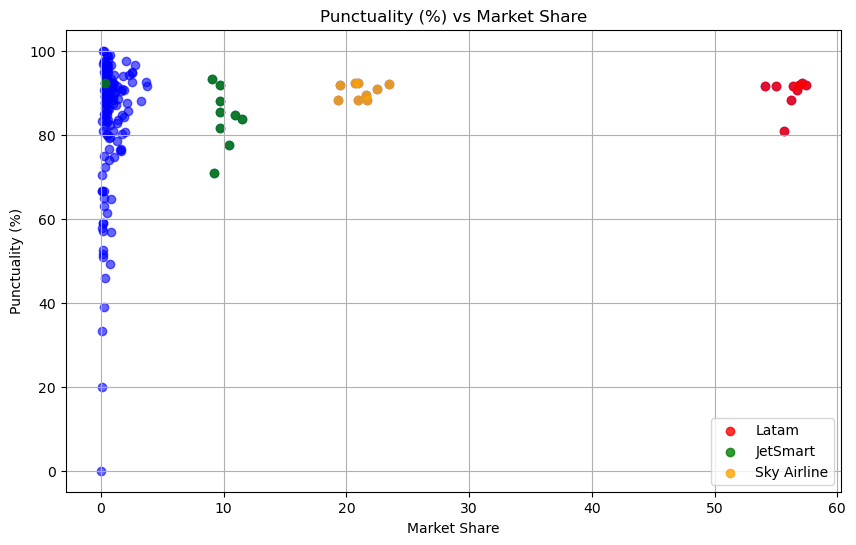

In [53]:
# caso de uso 1

import matplotlib.pyplot as plt

colors = {
    'Latam': 'red',
    'JetSmart': 'green',
    'Sky Airline': 'orange'
}


plt.figure(figsize=(10, 6))
plt.scatter(dfreg1b['Market Share'], dfreg1b['Punctuality (%)'], color='blue', alpha=0.6)


for airline in ['Latam', 'JetSmart', 'Sky Airline']:
    airline_data = dfreg1b[dfreg1b['Airline'] == airline]
    plt.scatter(airline_data['Market Share'], airline_data['Punctuality (%)'], 
                color=colors[airline], alpha=0.8, label=airline)

plt.title('Punctuality (%) vs Market Share')
plt.xlabel('Market Share')
plt.ylabel('Punctuality (%)')

plt.grid(True)
plt.legend()
plt.show()



In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


missing_data = {
    'Year': [2020, 2020, 2020, 2021, 2021, 2021, 2021, 2022],
    'Quarter': [2, 3, 4, 1, 2, 3, 4, 1],
    'HHI_quarter': [0]*8
}


missing_df = pd.DataFrame(missing_data)

HHI_graph2 = pd.concat([HHI_graph, missing_df], ignore_index=True)


HHI_graph2['Year_Quarter'] = HHI_graph2['Year'].astype(str) + ' Q' + HHI_graph2['Quarter'].astype(str)

HHI_graph2 = HHI_graph2.sort_values(by=['Year', 'Quarter'])

HHI_graph2['HHI_quarter'] = HHI_graph2['HHI_quarter'].replace(0, np.nan)
print(HHI_graph2)



    Year  Quarter  HHI_quarter Year_Quarter
0   2019        1  3677.720502      2019 Q1
1   2019        2  3744.266345      2019 Q2
2   2019        3  3782.383891      2019 Q3
3   2019        4  3786.296701      2019 Q4
4   2020        1  3753.100118      2020 Q1
9   2020        2          NaN      2020 Q2
10  2020        3          NaN      2020 Q3
11  2020        4          NaN      2020 Q4
12  2021        1          NaN      2021 Q1
13  2021        2          NaN      2021 Q2
14  2021        3          NaN      2021 Q3
15  2021        4          NaN      2021 Q4
16  2022        1          NaN      2022 Q1
5   2022        2  3513.376786      2022 Q2
6   2022        3  3798.299924      2022 Q3
7   2022        4  3775.872034      2022 Q4
8   2023        1  3702.132464      2023 Q1


C:\Users\rafae\AppData\Local\Temp\ipykernel_16196\302099039.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(HHI_graph2['Year_Quarter'], rotation=45)


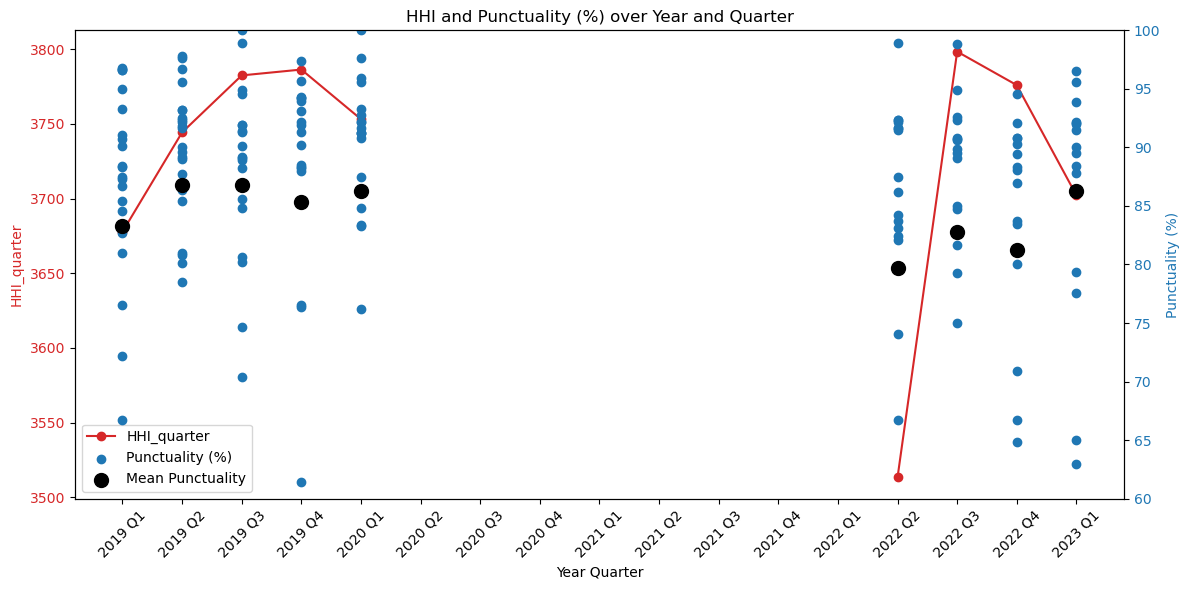

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

dfreg1b['Year_Quarter'] = dfreg1b['Year'].astype(str) + ' Q' + dfreg1b['Quarter'].astype(str)


mean_punctuality = dfreg1b.groupby('Year_Quarter')['Punctuality (%)'].mean()

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_xlabel('Year Quarter')
ax1.set_ylabel('HHI_quarter', color='tab:red')
line1, = ax1.plot(HHI_graph2['Year_Quarter'], HHI_graph2['HHI_quarter'], marker='o', color='tab:red', label='HHI_quarter')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_xticklabels(HHI_graph2['Year_Quarter'], rotation=45)

ax2 = ax1.twinx()
ax2.set_ylabel('Punctuality (%)', color='tab:blue')
scatter2 = ax2.scatter(dfreg1b['Year_Quarter'], dfreg1b['Punctuality (%)'], color='tab:blue', label='Punctuality (%)')
ax2.tick_params(axis='y', labelcolor='tab:blue')

ax2.set_ylim(60, 100)

ax2.scatter(mean_punctuality.index, mean_punctuality.values, color='black', s=100, label='Mean Punctuality', zorder=5)

plt.title('HHI and Punctuality (%) over Year and Quarter')
fig.tight_layout()

lines = [line1, scatter2]
labels = [line1.get_label(), scatter2.get_label()]
ax1.legend(lines + [ax2.collections[-1]], labels + ['Mean Punctuality'], loc='lower left')

plt.show()
